# Machine Learning Optimizers

We will introduce different gradient-based iterative optimization techniques which came from the domain of convex optimization and which have since been adapted for loss functions of modern neural networks that have millions of parameters. Try out a few of these to appreciate the improvements they make on each other. Specifically, we will look at:
    
* **Full Gradient Descent**
* **Stochastic Gradient Descent**
* **Stochastic Gradient Descent + Momentum**
* **AdaGrad**
* **Adaptive Moment Estimation (ADAM)**

## Section 1: Optimization

**In the following part, we will introduce several functions. Each has specific features that may cause problems (saddle, local min, e.t.c.) for gradient descent to find the global min.** 

**Thus they are good examples for us to experiment and understand the performance of each optimizer**

for $x, y \in X$ and $0 \leq \theta \leq 1$. In $\mathbb{R}^3$ the **bowl** or **sphere** function is the archetypical convex function.

$$f(x, y) = x^2 + y^2$$

While convex theory gives convenient bounds on gradient based optimization, it is not enough to stop here as we do not expect the loss function for our machine learning models to be convex. Optimization research then focuses on studying the behavior of algorithms on test functions that accentuate some of the possible problematic optimization scenarios we might run into on a loss manifold in higher dimensions. For example, one potential issue we have studied in class is that in an iterative optimization process, we might get stuck in a local optima. A potential test function that could especially be indicative of if an optimization algorithm handles this issue, is the following function, which we will call the **mult** function:

$$f(x, y) = \sin(\sqrt(x^2 + y^2)) $$

Another issue could be a point which has different signs to its curvature in different directions, but locally has no gradient, aka a saddle point. A "test" function to effectively evaluate an algorithm's performance on saddle points could be 

$$f(x, y) = x^3 + 3x y^2$$

or otherwise known as the **monkey saddle**. 

As a final example, it might be concerning if a point has a very high gradient in one direction but extremely low gradient aka a high condition number is associated with its eigendecomposition of the Hessian (if you didn't understand this last line, that's fine- the Hessian only comes into play while giving a proof of convergence for convex functions for gradient descent and such theory is beyond the scope of this class. An alternate way of thinking why this is an issue is because it will cause a zig-zag convergence to the optima when we can potentially save a lot of iterations by just taking a step along one axis). A function to test convergence performance emperically for this issue could be one shaped like a taco shell. A well known function of this kind is the **Matyas** function.

$$f(x, y) = 0.26(x^2 + y^2) -0.48xy$$

Bonus point for figuring out who the **Matyas** function is named after, because I looked forever in the hopes of adding a half-clever note on who Matyas was to improve the readability of this homework with a casual fun fact that has nothing to do with machine learning, but I ended up getting lost online and achieving nothing for 30 mins.

**Implement the said functions below as bowl, mult, monkey and matyas and use the plot function below to visualize what they look like. **

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import matplotlib.colors
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial


def bowl():
    '''
    bowl function is well-defined on R^2 a and satisfies Jenson's inequality,
    thus is a convex function. 
    Can be used to verify if the optimizer is reasonable (goes towards min) before
    performing further test about local min and saddle point.
    And bowl function is easy to visualize, which 
    makes it a good test function
    '''


    def f_bowl(x, y):
        
        out = x ** 2 + y ** 2
    
        return out
    
    def opt_bowl():
        
        return np.array([0., 0.])
    return f_bowl, opt_bowl

    
    
def mult():
    '''
    Mult contains infinite amount of global min, and one unique local min,
    Can be used to test if the optimizer will be trapped in the local min
    also easy to visualize
    '''
    
    def f_mult(x, y):

        out = np.sin(np.sqrt(x**2 + y**2))
        
        return out
    
    def opt_mult():
        
        return np.array([0., 0.])
    
    return f_mult, opt_mult

def monkey():
    '''
    TODO
    It has only one critical point, which is a saddle point.
    And this saddle point is easy to escape, which can be used for
    basic test if an optimizer is able to handle saddle point.
    '''

    def f_monkey(x, y):

        out = x ** 3 + 3 * x * y ** 2
        
        return out
    
    def opt_monkey():
        
        return np.array([0., 0.])
    
    return f_monkey, opt_monkey

    
def matyas():
    '''
    Matyas contains points having a very high gradient in one direction 
    but extremely low gradient which makes it hard to convergent, thus
    Matyas can be used to test the speed of convergence of an optimizer.
    '''

    def f_matyas(x, y):

        out = 0.26 * (x**2 + y**2) - 0.48 * x * y
        
        return out
    
    def opt_matyas():
        
        return np.array([0., 0.])
        
    
    return f_matyas, opt_matyas


def plot_func(f):
    
    func, opt = f()
    
    #Set grid parameters
    xmin = -4.5
    xmax= 4.5
    ymin = -4.5
    ymax = 4.5
    step = 0.2
    
    x, y = np.meshgrid(np.arange(xmin, xmax + step, step), np.arange(ymin, ymax + step, step))
    z = func(x, y)
    cp = opt()
    optima = cp.reshape(-1, 1)
    
    fig = plt.figure(figsize=(12,6), dpi = 100)
    ax = fig.add_subplot(1,2,1,projection='3d')
    ax.plot_surface(x, y, z,  rstride=5, cstride=5, alpha = 0.5, cmap=plt.cm.plasma)
    cset = ax.contourf(x, y, z, 25, zdir='z', offset=-1, alpha=0.6, cmap=plt.cm.coolwarm)
    out1 = func(*optima)
    
    ax.plot(*optima, out1 , 'r*', markersize=10)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

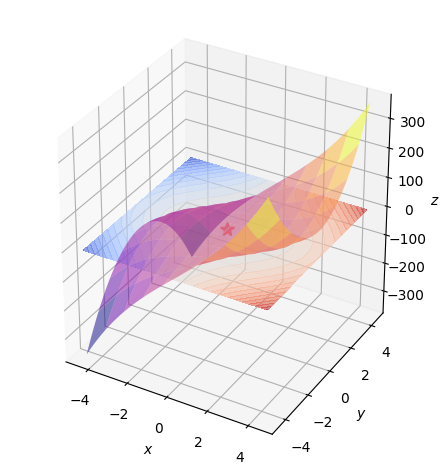

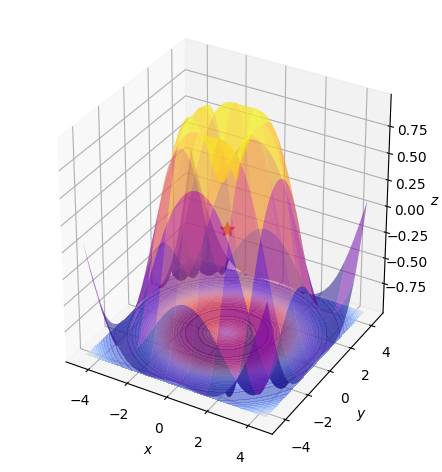

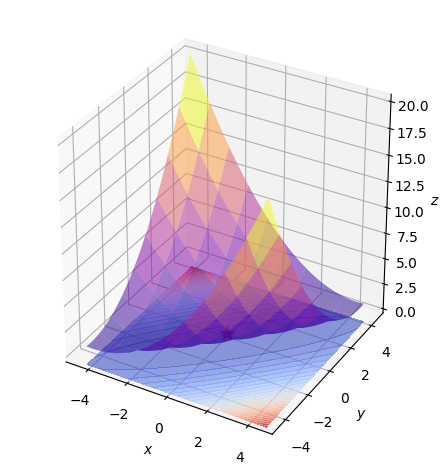

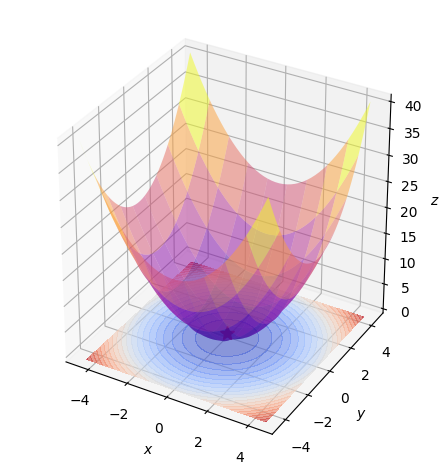

In [22]:
plot_func(monkey)
plot_func(mult)
plot_func(matyas)
plot_func(bowl)

## Gradient Descent 

$$ \theta = \theta - \alpha \nabla_{\theta}\mathcal{L}(\theta)$$

We computed the gradient with respect to each of the parameters and make an update in the opposite direction of the local gradient. $\alpha$ which is the learning rate, is a hyperparam that controls how quickly gradient descent converges. If it is too low, too many updates may be required, especially as gradients are small, and if it is too large you may overshoot the optima. In the context of batch gradient descent- at each epoch where the above update is ran- batch gradient descent requires that the entire loss function be computed at each stage through a pass through the entire training data so that the calculation of the $\mathcal{L}(\theta)$ and its subsequent gradient be accurate. As a result, this method is usually very slow. Additionally, it is only guaranteed to converge to the global minimum for convex functions such as the bowl functions and this is often not the case in machine learning, in which case it is guaranteed to only converge to local minima.

Implement a version of gradient descent below.

In [23]:
def gradient_descent(x, y, dx, dy, hparams):
    
    alpha = hparams['alpha']

    x = x - alpha * dx
    y = y - alpha * dy
    
    return x, y 

## Stochastic Gradient Descent

$$ \theta = \theta - \alpha \nabla_{\theta}\mathcal{L}(\theta; x^i, y^i)$$

This method is very similar to full gradient descent, except that instead of calculating the loss function over all training examples, the loss function is only calculated over a single training data point at a time. As such the estimate of $\mathcal{L}(\theta)$ and its gradient is not precise, but in return, SGD is much faster, and additionally reduces redundant time for recomputing gradients for similar examples.

Gradients received can be highly erratic because they are not calculated over the full dataset, and as a result the optimization path will often zig zag and occasionally spiral out of control. It has been shown that with enough control over the learning rate, sgd and batch gradient descent often achieve the same results, but SGD does it much faster in the context of machine learning. A commonly used variant of gradient descent that sits between full and stochastic gradient descent is mini-batch gradient descent where the gradient and loss function are calculated over a randomly chosen fixed size batch of training examples.

Implement a version of stochastic gradient descent below. Since we are not actually using a dataset or even a data distribution to generate our "loss" manifold that we are trying to optimize over, you should simulate the effect of approximation using gaussian noise on the gradients. Feel free to use the gauss function imported below for the same.

In [24]:
from random import gauss

def stochastic_gradient_descent(x, y, dx, dy, hparams):
    '''
    x: value of x before update
    y: value of y before update
    dx: derivative wrt x
    dy: derivative wrt y
    hparams must contain alpha
    '''
    
    alpha = hparams['alpha']
    
    dx += gauss(0, 1)
    dy += gauss(0, 1) 

    x = x - dx * alpha
    y = y - dy * alpha
    
    return x, y

## Stochastic Gradient Descent and Momentum

$$ \nu_t = \gamma\nu_{t-1} + \alpha \nabla_{\theta}\mathcal{L}(\theta; x^i, y^i) $$
$$ \theta = \theta - \nu_t $$

Stochastic Gradient Descent suffers very heavily if the loss function changes very quickly in one direction and slowly in another direction (eg. taco shell function) In this case the direction of the gradient does not align with the direction toward the minimum and a zig zag motion is direction with slower gradients. This is the case where the Hessian of the loss function wrt parameters has a high condition number, aka the eigenvalues of the representative matrix have a high ratio between the highest and the lowest eigenvalue. 

The use of the word momentum is a metaphor in this context, as such a method allows the navigation of shallow local optima or the navigation of ravines using the build-up of gradients from the navigation. The idea is that we maintain what is a 'velocity' term $\nu$ at each timestep that keeps track of how much gradient has so far been encountered. Hence this value builds up in each direction and even in cases when gradients received in training are poor (eg. around saddle points, or local minima), the algorithm is able to escape such points (much like a ball rolling down a hill). The term for gamma, which is a hyperparameter, can be thought of as friction for the build-up of this velocity, as it decides how much of the previous velocity to count at a certain timestep. Even in the case of a ravine, the zig-zag motion of stochastic gradient descent would reduce as the buildup term in one direction would carry us smoothly through the low-gradient sensitive dimension. The momentum vectors also help cancel/smooth some of the noise that results from approximating gradients using a single data point, aka, the stochastic way.

This method has its own flaws: it might settle in extremely deep minima. Such minima are not desirable even as global minima, as on a data manifold they may be "too good" to be true; representative of a kind of overfit. An example test function for this issue is the **Easom function**. The good news is that with some tuning of **gamma** more often that never SGD + momentum will settle in shallow, wide minima.

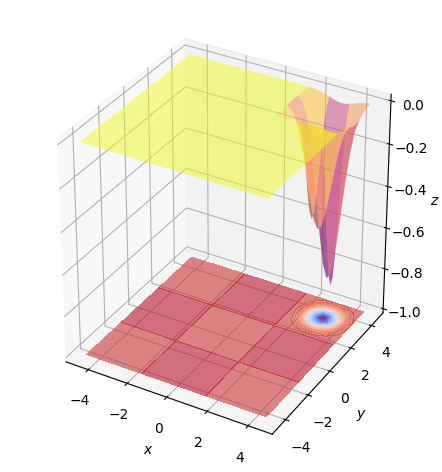

In [25]:
def easom():
    '''
    Easom has multiple local min and a global min. Can be used
    to test if the optimizer can escape thess local mins and
    end up in the global min
    '''
    
    def f_easom(x, y):
        out = -np.cos(x)*np.cos(y)*np.exp(-(x-np.pi)**2 - (y-np.pi)**2)

        return out
        
    def opt_easom():
        
        return np.array([np.pi, np.pi])
    
    
    return f_easom, opt_easom
        
plot_func(easom)

Implement your version of stochastic gradient descent with momentum below.

In [26]:
def momentum(x, y, dx, dy, v_x, v_y, hparams):
    '''
    x: value of x before update
    y: value of y before update
    dx: derivative wrt x
    dy: derivative wrt y
    v_x: velocity parameter wrt x
    v_y: velocity parameter wrt y
    hparams must contain alpha and gamma
    '''
    
    alpha = hparams['alpha']
    gamma = hparams['gamma']
    
    dx += gauss(0, 1)
    dy += gauss(0, 1)

    v_x = gamma * v_x + alpha * dx
    v_y = gamma * v_y + alpha * dy
    x -= v_x
    y -= v_y
    
    return x, y, v_x, v_y

## Nesterov Momentum

$$ \nu_t = \gamma\nu_{t-1} + \alpha \nabla_{\theta}\mathcal{L}(\theta - \gamma\nu_{t-1}) $$
$$ \theta = \theta - \nu_t $$

A problem with momentum is that there is no way to control the slow-down of the optimizer even as we approach a minima- the optimizer isn't smart enough to decide whether or not it needs to continue up a slope once it has reached a (local or global) minima. A version of momentum, called Nesterov momentum helps deal with this problem by first changing parameters in the direction of the accumulated gradient, estimating the destination gradient and then making an update in that direction.

You do not have to implement nesterov updates.

## AdaGrad

Adagrad is another approach toward solving some of the same problems that momentum attempts to solve. However, it does more by giving the optimizer the ability to adapt updates for individual parameters depending on their importance. It adapts its learning rate to make higher updates (higher learning rate) for dimensions/features with higher values and lower updates (low learning rate) for dimensions/features with lower values.

$$ G_{i, i}^{t+1} = G_{i, i}^{t} + (\frac{\delta\mathcal{L}(\theta)}{\delta\theta_i})^2 $$
$$ \theta_{t,i} = \theta_{t-1, i} - \frac{\alpha}{\sqrt{G_{i,i} + \epsilon}}\nabla_{\theta}\mathcal{L}(\theta_{t, i}) $$

Here $G$ starts off as a 0 matrix and builds up squared gradients for each feature/dimension which is later used to scale the value for the parameter updates. $\epsilon$ is generally a very small number to ensure that division by zero does not occur in case the initialization point provides no gradient. The biggest advantage of adagrad is that it takes away the need to manually tune the learning rate as is required with SGD, and provides feature-tuned learning rates. However, because of the way adagrad adjusts learning rates it sometimes tends to work well only with convex problems, as with non-convex problems in runs into issues with how to overshooting local minima/saddle points as it slows down rapidly due to accumulating squared gradients. It also provides really slow initial updates if the gradients at the initialization point are really high.

Implement your variant of Adagrad below.



In [27]:
def adagrad(x, y, dx, dy, v_x, v_y, hparams):
    '''
    x: value of x before update
    y: value of y before update
    dx: derivative wrt x
    dy: derivative wrt y
    v_x: velocity parameter wrt x
    v_y: velocity parameter wrt y
    hparams must contain eps and alpha
    '''
    
    eps = hparams['eps']
    alpha = hparams['alpha']
    
    dx += gauss(0, 1)
    dy += gauss(0, 1)

    v_x = v_x + dx**2
    v_y = v_y + dy**2
    x -= alpha / (np.sqrt(v_x+eps)) * dx
    y -= alpha / (np.sqrt(v_y+eps)) * dy
    
    return x, y, v_x, v_y

**RMSProp** and **AdaDelta** are two different algorithms that combat the aggressive learning rate reduction that comes with AdaGrad.

## Adaptive Momentum Estimation

This is the **best of all worlds** update algorithm. The second line (f) accumulated gradients much like momentum, while the third line (s) accumulates gradient squared for adjusting the learning rates like AdaGrad. These have to be adjusted in lines 3 and 4, because they are initialized to 0 at the beginning of optimization and since f is in the numerator of the final update we cannot afford to multiply by a really small number, neither can we afford to divide by a really small number. $\beta_1$ and $\beta_2$ must be less than 1 and are typically initialized high values such as 0.9 or 0.99. Yhe unbiasing operations on line 4 and 5 above help bring up the values of f and s early in training. 
    

$$ g_{t, i} = \nabla_{\theta}\mathcal{L}(\theta_{t, i}) $$
$$ f_{t, i} = \beta_1 f_{t-1, i} + (1-\beta_1) g_{t, i} $$ 

$$ s_{t, i} = \beta_2 s_{t-1, i} + (1-\beta_2) g_{t, i}^2 $$
$$ \hat{f_{t, i}} = \frac{f_{t, i}}{1 - \beta_1^t}$$
$$ \hat{s_{t, i}} = \frac{s_{t, i}}{1 - \beta_2^t}$$
$$ \theta_{t+1,i} = \theta_{t, i} - \frac{\alpha\hat{f_{t, i}}}{\sqrt{\hat{s_{t, i}} + \epsilon}}$$

Implement your function for adam below. Follow the comments closely for interpretation of inputs and outputs.

In [28]:
def adam(x, y, dx, dy, f_x, f_y, s_x, s_y, i, hparams):
    '''
    x: value of x before update
    y: value of y before update
    dx: derivative wrt x
    dy: derivative wrt y
    f_x, f_y: first order gradient accumulators
    s_x, s_y: second order gradient accumulators
    i: number of iteration
    hparams must contain alpha, eps, beta_1 and beta_2
    '''
    
    eps = hparams['eps']
    alpha = hparams['alpha']
    beta_1 = hparams['beta_1']
    beta_2 = hparams['beta_2']
    
    #CODE HERE
    dx += gauss(0, 1)
    dy += gauss(0, 1)

    f_x = beta_1 * f_x + (1 - beta_1) * dx
    f_x_hat = f_x / (1 - beta_1**(i+1))
    s_x = beta_2 * s_x + (1 - beta_2) * dx**2
    s_x_hat = s_x / (1 - beta_2**(i+1))
    x = x - alpha * f_x_hat / np.sqrt(s_x_hat + eps)

    f_y = beta_1 * f_y + (1 - beta_1) * dy
    f_y_hat = f_y / (1 - beta_1**(i+1))
    s_y = beta_2 * s_y + (1 - beta_2) * dy**2
    s_y_hat = s_y / (1 - beta_2**(i+1))
    y = y - alpha * f_y_hat / np.sqrt(s_y_hat + eps)
    
    return x, y, f_x, f_y, s_x, s_y    

Study in detail the class Optimizer that has been implemented below, because you will be using it to study the effect of key hyperparameters on the optimization process, and the difference that the bells and whistles on Gradient Descent can make. The **fit** function calls the methods you have implemented above depending on how you initialize the class.

In [29]:
from random import seed
import math

seed(1)

class Optimizer:
    
    def __init__(self, x_init, y_init, method, func, hparams):
        
        '''
        x_init: Initialization x point
        y_init: Initialization y point
        method: adam, adagrad, sgrad, ... check the fit function below
        func: function to optimize [mult, easom, monkey, bowl, matyas, ...]
        hparams: alpha, gamma, eps, beta, beta_1, beta_2
        '''
        
        f, optima = func()
        
        self.x = x_init
        self.y = y_init
        self.hparams = hparams
        self.first = True
        self.iter = 0
        self.x_list = []
        self.y_list = []
        
        cp = optima()
        self.cp_x = np.asscalar(np.array([0]))
        self.cp_y = np.asscalar(np.array([1]))
        
        self.method = method
        self.f = f
        self.f_gradx = grad(f, 0)
        self.f_grady = grad(f, 1)
        self.count = 0
        
    def distance(self, x, y):
        '''
        L2 Norm
        '''
        
        return math.sqrt((x-self.cp_x)**2 + (y-self.cp_y)**2)
        
    def cgrad(self, x, y):
        '''
        Uses autograd
        '''
        
        return self.f_gradx(x, y), self.f_grady(x, y)
        
    def fit(self, epochs):

        '''
        Epochs: max number of updates to be made
        '''

        
        self.x_list = []
        self.y_list = []
        self.z_list = []
        
        if self.method == 'grad':
            
            '''
            USES
            alpha: learning rate'
            '''
            
            for i in range(epochs):
                
                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y = gradient_descent(self.x, self.y, dx, dy, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
                    
                
        if self.method == 'sgrad':
            
            '''
            USES
            alpha: learning rate
            '''
            
            for i in range(epochs):

                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y = stochastic_gradient_descent(self.x, self.y, dx, dy, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
        
                
                
        if self.method == 'grad_momentum':
            
            '''
            USES
            alpha: learning rate
            gamma: momentum factor
            '''
            
            v_x, v_y = 0., 0.
            for i in range(epochs):
                
                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y, v_x, v_y = momentum(self.x, self.y, dx, dy, v_x, v_y, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
                
        if self.method == 'adagrad':
            
            '''
            USES
            alpha: learning rate
            eps: 
            '''
            
            v_x, v_y = 0., 0.
            for i in range(epochs):
                
                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y, v_x, v_y = adagrad(self.x, self.y, dx, dy, v_x, v_y, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
                    
                
        if self.method == 'adam':
            
            '''
            USES
            alpha: learning rate
            beta_1:
            beta_2:
            eps: 
            '''
            
            f_x, f_y = 0., 0.
            s_x, s_y = 0., 0.
            for i in range(epochs):

                self.x_list.append(self.x)
                self.y_list.append(self.y)
                self.z_list.append(self.f(self.x, self.y))
                
                dx, dy = self.cgrad(self.x, self.y)
                
                self.x, self.y, f_x, f_y, s_x, s_y = adam(self.x, self.y, dx, dy, f_x, f_y, s_x, s_y, i, self.hparams)
                
                if (self.distance(self.x, self.y) < 1 and self.first):
                    self.iter = i
                    self.first = False
          

The code at the bottom provides helper functions to help you visualize your results and play around with your optimizer implementations.

In [30]:
def animate(i):
    '''Plotting helper'''
    
    i = int(i*(epochs/frames))
    line1.set_data(optim.x_list[:i+1], optim.y_list[:i+1])
    line1.set_3d_properties(optim.z_list[:i+1])
    line2.set_data(optim.x_list[:i+1], optim.y_list[:i+1])
    line2.set_3d_properties(np.zeros(i+1) -1)
    title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, optim.z_list[i]))
    
    return line1, line2, title


def plot_function(epochs, frames, func, xmin = -4.5, xmax= 4.5, ymin = -4.5, ymax = 4.5, step = 0.2, option = '3d'):

    '''
    Plot the optimization
    epochs: number of optimization improvements
    frames: number of displayed frames
    func: function to plot. eg. mult, monkey, ....
    xmin: Min value of x to be displayed
    xmax: Max value of x to be displayed
    ymin: Min value of y to be displayed
    ymax: Max value of y to be displayed
    step: Split between xmin and xmax, ymin and ymax
    option: keep this option '3d'

    '''    

    x, y = np.meshgrid(np.arange(xmin, xmax + step, step), np.arange(ymin, ymax + step, step))
    f, opt = func()
    z = f(x, y)
    cp = opt()
    
    optima = cp.reshape(-1, 1)
    
    if (option == '3d'):
        
        fig = plt.figure(figsize=(12,6), dpi = 100)
        ax = fig.add_subplot(1,2,1,projection='3d')

        ax.plot_surface(x, y, z,  rstride=5, cstride=5, alpha = 0.5, cmap=plt.cm.plasma)
        cset = ax.contourf(x, y, z, 25, zdir='z', offset=-1, alpha=0.6, cmap=plt.cm.coolwarm)
        out1 = f(*optima)
        ax.plot(*optima, out1 , 'r*', markersize=10)

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')
        
        
        i = 0

        for i in range(epochs):
            line1, = ax.plot(optim.x_list[:i+1], optim.y_list[:i+1], optim.z_list[:i+1], color ='black', marker = '.')

            line2, = ax.plot(optim.x_list[:i+1], optim.y_list[:i+1], np.zeros(i+1)-1, color ='red', marker='.')
            
    
    if (option == '2d'):
        
        fig = plt.figure(dpi = 100)
        ax = plt.subplot(111)
        
        cset = ax.contourf(x, y, z, 25, zdir='z', offset=-1, alpha=0.6, cmap=plt.cm.bwr)
        
        dz_dx = egrad(f, argnum=0)(x, y)
        dz_dy = egrad(f, argnum=1)(x, y)
        ax.quiver(x, y, x- dz_dx, y-dz_dy, alpha = 0.5)
        ax.plot(*optima, 'r*', markersize = 18)

        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')


    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show

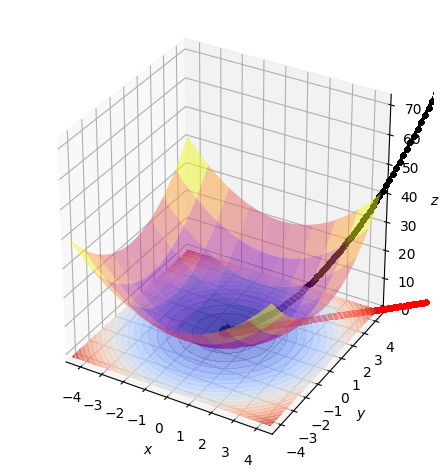

In [31]:
'''
Test plot: Here, we plot optimization with adam on bowl function for 200 updates,
initialized at (6., 6.).
'''

frames = 20
epochs = 200

func = bowl
init_x, init_y = 6., 6.

hparams = {'alpha': 0.1, 'eps': 1e-7, 'beta_1': 0.8, 'beta_2': 0.99}
optim = Optimizer(init_x, init_y, 'adam', func, hparams)
optim.fit(epochs)

plot_function(epochs, frames, func)

# Importance of learning rate

Call the plotting function and Optimizer as shown above and make two plots to show how too high or too low of a learning rate could be a problem for stochastic gradient descent on the bowl function. Keep the number of iterations (epochs) constant across the two to demonstrate the effect. You are recommended to use the bowl function.


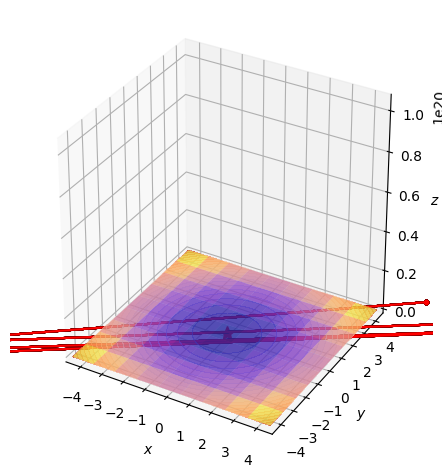

In [32]:
frames = 20
epochs = 20

'''
Make a plot to show what happens if the learning rate is too high with sgrad.
'''

func = bowl
#CODE HERE
hparams = {'alpha': 2}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

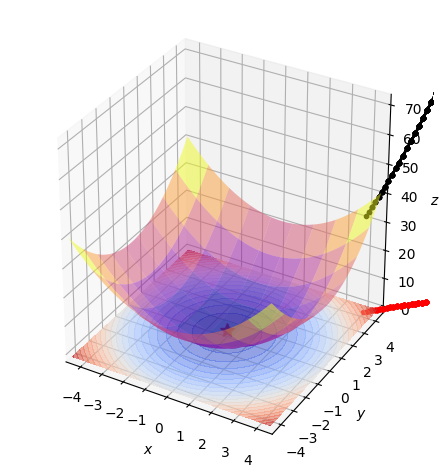

In [33]:
frames = 20
epochs = 20

'''
Make a plot to show what happens if the learning rate is too low with sgrad.
'''

func = bowl
hparams = {'alpha': 0.01}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

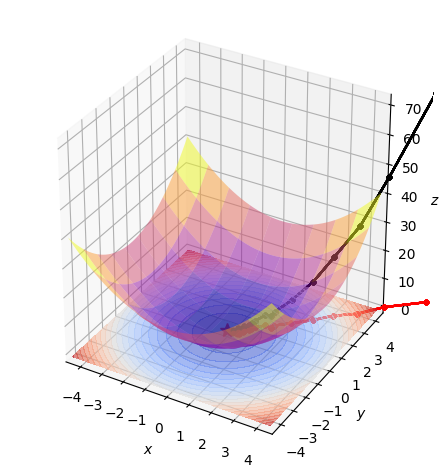

In [34]:
'''
Make a plot to show what happens if the learning rate is just right with sgrad.
'''

frames = 20
epochs = 20

func = bowl
#CODE HERE
hparams = {'alpha': 0.1}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

# SGD and Matyas: momentum helps

Make two plots to show how momentum possibly helps with navigating a taco-shell function like Matyas, where gradient is low in one direction and high in another direction. Keep all parameters except the type of optimizer constant. 

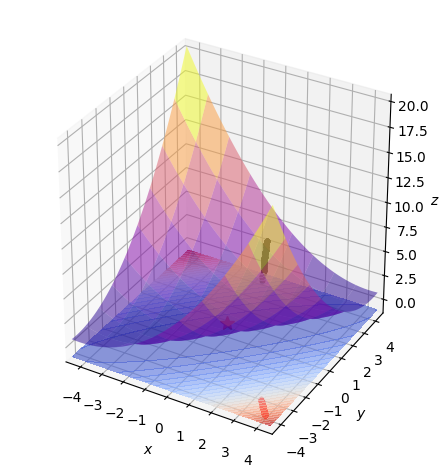

In [35]:
frames = 20
epochs = 20

'''
Make a plot to show what happens if stochastic gradient descent is used on a 
function like this.
'''

func = matyas
init_x, init_y = (4., -4.)
hparams = {'alpha': 0.01}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

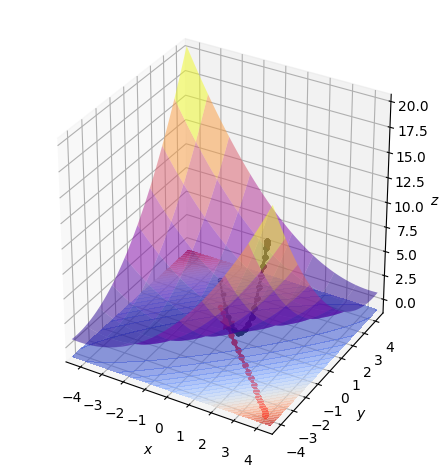

In [56]:
frames = 20
epochs = 20

'''
Make a plot to show what happens if stochastic gradient descent with momentum
is used on a function like this.
'''

func = matyas
init_x, init_y = (4., -4.)
hparams = {'alpha': 0.01, 'gamma':0.99}
optim = Optimizer(init_x, init_y, 'grad_momentum', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

# Exploring Saddle Points

Make three plots to show how SGD, momentum, and adagrad behave on the monkey function. A good optimization algorithm will move past the flat region and continue its trajectory downward. Do not change the learning rate as this has been artificially reduced to make the distinction clear on this problem. Do you notice the observations made in the text above?

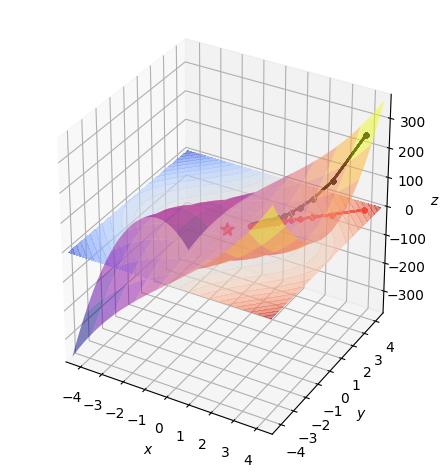

In [37]:
frames = 20
epochs = 20

'''
Make a plot to show what happens if stochastic gradient descent is used on a 
function like this.
'''

func = monkey
init_x, init_y = (4., 4.)
hparams = {'alpha': 0.01}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

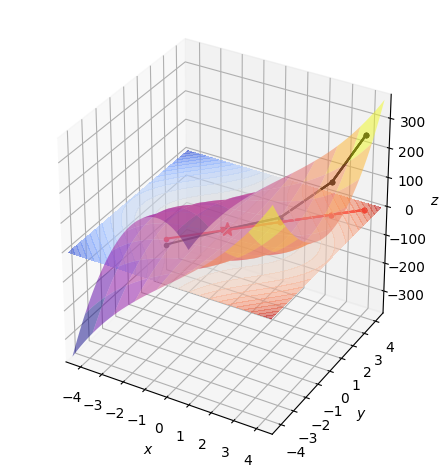

In [57]:
frames = 20
epochs = 5

'''
Make a plot to show what happens if stochastic gradient descent with momentum
is used on a function like this.
'''

func = monkey
init_x, init_y = (4., 4.)
hparams = {'alpha': 0.01, 'gamma': 0.99}
optim = Optimizer(init_x, init_y, 'grad_momentum', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

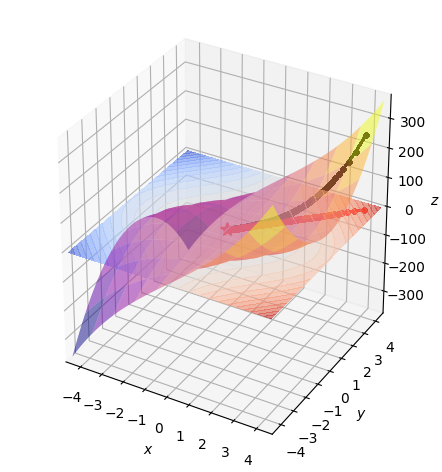

In [39]:
frames = 20
epochs = 1000

'''
Make a plot to show what happens if adagrad
is used on a function like this.
'''

func = monkey
init_x, init_y = (4., 4.)
hparams = {'alpha': 0.3, 'gamma': 0.99, 'eps': 1e-7}
optim = Optimizer(init_x, init_y, 'adagrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

# Escaping Local Minima 

Make 3 or more plots (with atleast one plot using ADAM) to show how the different functions escape the local minima on the **mult** function. We will initialize at (0.5, 0.5).

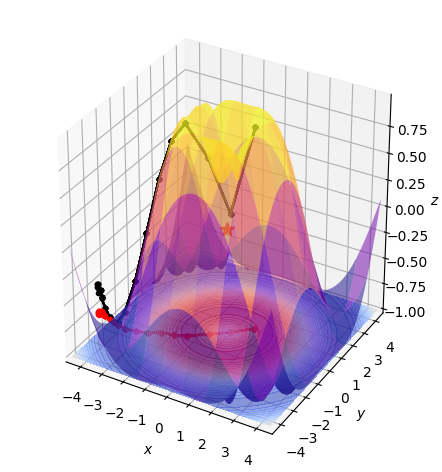

In [40]:
frames = 20
epochs = 20

'''
Make a plot to show what happens if ADAM
is used on a function like this.
'''


func = mult
#CODE HERE
init_x, init_y = (0.8, 0.8)
hparams = {'alpha': 0.7, 'eps': 1e-7, 'beta_1': 0.99, 'beta_2': 0.9} 
optim = Optimizer(init_x, init_y, 'adam', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

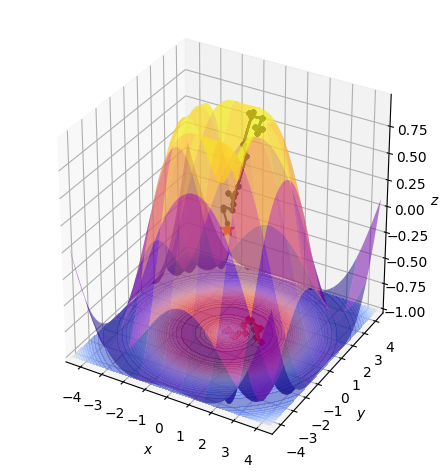

In [60]:
frames = 20
epochs = 20

'''
Make a plot to show what happens if adagrad
is used on a function like this.
'''

func = mult
#CODE HERE
init_x, init_y = (0.8, 0.8)
hparams = {'alpha': 0.7, 'eps': 1e-7, 'beta_1': 0.99, 'beta_2': 0.9, 'eps':1e-7} 
optim = Optimizer(init_x, init_y, 'adagrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

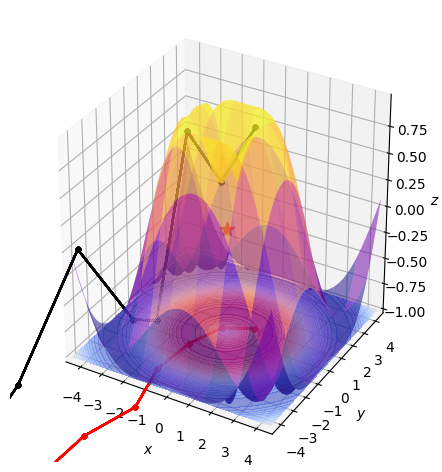

In [68]:
frames = 20
epochs = 20


'''
Make a plot to show what happens if stochastic gradient descent with momentum
is used on a function like this.
'''


func = mult
init_x, init_y = (.8, .8)
hparams = {'alpha': 0.7, 'gamma':0.99}
optim = Optimizer(init_x, init_y, 'grad_momentum', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

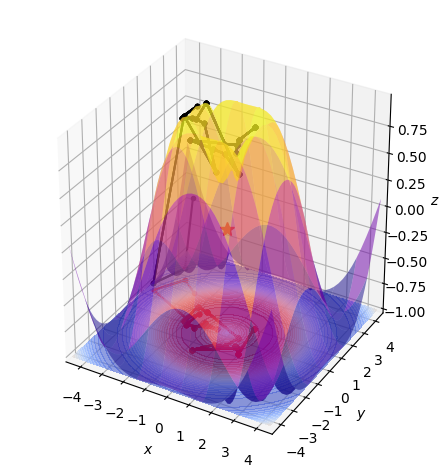

In [70]:
frames = 20
epochs = 20


'''
Make a plot to show what happens if stochastic gradient descent with momentum
is used on a function like this.
'''

func = mult
#CODE HERE
init_x, init_y = (.8, .8)
hparams = {'alpha': 0.7, 'gamma':0.99}
optim = Optimizer(init_x, init_y, 'sgrad', func, hparams)
optim.fit(epochs)
plot_function(epochs, frames, func)

# Acknowledgement
==================   
This note is mainly based on assignment of COMS 4732 at Columbia By professor Carl Vondrick